# CNN MultiOutput test

* テスト用に作成したデータで学習してみる

In [1]:
import os
import time as ti
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn import model_selection
from sklearn import preprocessing

import librosa
import librosa.display

import tensorflow
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Activation
from keras.layers import Conv2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization, Add
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

import IPython.display as ipd

In [18]:
base_dir = "C:/Users/shuhei/anaconda3/envs/tensorflow/workspace/"
dataset_dir = os.path.join(base_dir, "dataset_each/")
asses_name_list = ["000000", "100000", "010000", "001000", "000100", "000010", "000001"]
guitar_dataset_dir = os.path.join("C:/Users/shuhei/anaconda3/envs/tensorflow/workspace/", "dataset_each_np/")

In [126]:
def load_wave_data(audio_dir, file_name):
    file_path = os.path.join(audio_dir, file_name)
    # サンプリングレートはデフォルトで22050
    x, fs = librosa.load(file_path)
    return x, fs

def calculate_melsp(x, n_fft=1024, hop_length=128):
    stft = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop_length))**2
    log_sftf = librosa.power_to_db(stft)
    melsp = librosa.feature.melspectrogram(S=log_sftf, n_mels=128)
    return melsp

def show_wave(x):
    plt.plot(x)
    plt.show()

def show_melsp(melsp, fs):
    librosa.display.specshow(melsp, sr=fs, y_axis='mel', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

def add_white_noise(x, rate=0.002):
    return x + rate*np.random.randn(len(x))

def shift_sound(x, rate=2):
    return np.roll(x, int(len(x)//rate))

def stretch_sound(x, rate=1.1):
    input_length = len(x)
    x = librosa.effects.time_stretch(y=x, rate=rate)
    if len(x) > input_length:
        return x[:input_length]
    else:
        return np.pad(x, (0, max(0, input_length - len(x))), "constant")

def change_volume(x, rate=1.0):
    return x * rate

def save_np_data(filename, x, y, aug=None, rates=None):
    np_data = np.zeros(freq*time*len(x)).reshape(len(x), freq, time)
    np_targets = np.zeros(len(y))
    for i in range(len(y)):
        _x, fs = load_wave_data(dataset_dir, x[i])
        if aug is not None:
            _x = aug(x=_x, rate=rates[i])
        _x = calculate_melsp(_x)
        np_data[i] = _x
        np_targets[i] = y[i]
    np.savez(filename, x=np_data, y=np_targets)

In [4]:
freq = 128
time = 517

In [75]:
x = []
y = []
for i in range(0, 7):
    for n in range(0, 30):
        file_name = asses_name_list[i] + "_" + str(n).zfill(3) + ".wav"
        x.append(file_name)
        y.append(i)

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.2, stratify=y)
print("x train:{0}\ny train:{1}\nx test:{2}\ny test:{3}".format(len(x_train),
                                                                len(y_train), 
                                                                len(x_test), 
                                                                len(y_test)))

x train:168
y train:168
x test:42
y test:42


In [19]:
# test data
path = os.path.join(guitar_dataset_dir, "gar_melsp_test.npz")
if not os.path.exists(path):
    save_np_data(path, x_test, y_test)

# train data
path = os.path.join(guitar_dataset_dir, "gar_melsp_train_raw.npz")
if not os.path.exists(path):
    save_np_data(path, x_train,  y_train)

path = os.path.join(guitar_dataset_dir, "gar_melsp_train_wn.npz")
if not os.path.exists(path):
    rates = np.random.randint(1,50,len(x_train))/10000
    save_np_data(path, x_train,  y_train, aug=add_white_noise, rates=rates)

path = os.path.join(guitar_dataset_dir, "gar_melsp_train_ss.npz")
if not os.path.exists(path):
    rates = np.random.choice(np.arange(2,6),len(y_train))
    save_np_data(path, x_train,  y_train, aug=shift_sound, rates=rates)

path = os.path.join(guitar_dataset_dir, "gar_melsp_train_st.npz")
if not os.path.exists(path):
    rates = np.random.choice(np.arange(80,120),len(y_train))/100
    save_np_data(path, x_train,  y_train, aug=stretch_sound, rates=rates)

path = os.path.join(guitar_dataset_dir, "gar_melsp_train_cv.npz")
if not os.path.exists(path):
    rates = np.random.choice(np.arange(30,200),len(y_train))/100
    save_np_data(path, x_train,  y_train, aug=change_volume, rates=rates)

path = os.path.join(guitar_dataset_dir, "gar_melsp_train_co.npz")
if not os.path.exists(path):
    np_data = np.zeros(freq*time*len(x_train)).reshape(len(x_train), freq, time)
    np_targets = np.zeros(len(y_train))
    for i in range(len(y_train)):
        x, fs = load_wave_data(dataset_dir, x_train[i])
        x = add_white_noise(x=x, rate=np.random.randint(1,50)/1000)
        x = change_volume(x=x, rate=np.random.randint(30,200)/100)
        if np.random.choice((True,False)):
            x = shift_sound(x=x, rate=np.random.choice(np.arange(2,6)))
        else:
            x = stretch_sound(x=x, rate=np.random.choice(np.arange(80,120))/100)
        x = calculate_melsp(x)
        np_data[i] = x
        np_targets[i] = y_train[i]
    np.savez(path, x=np_data, y=np_targets)

In [20]:
_train_files = ["gar_melsp_train_raw.npz", 
               "gar_melsp_train_ss.npz",
               "gar_melsp_train_st.npz", 
               "gar_melsp_train_wn.npz",
               "gar_melsp_train_cv.npz",
               "gar_melsp_train_co.npz"]
_test_file = "gar_melsp_test.npz"

train_files = [os.path.join(guitar_dataset_dir, path) for path in _train_files]
test_file = os.path.join(guitar_dataset_dir, _test_file)

In [21]:
train_num = 168
test_num = 42

In [90]:
x_train = np.zeros(freq*time*train_num*len(train_files)).reshape(train_num*len(train_files), freq, time)
y_train = np.zeros(train_num*len(train_files))

# 訓練データのロード
for i in range(len(train_files)):
    data = np.load(train_files[i])
    x_train[i*train_num:(i+1)*train_num] = data["x"]
    y_train[i*train_num:(i+1)*train_num] = data["y"]


# テストデータのロード
test_data = np.load(test_file)
x_test = test_data["x"]
y_test = test_data["y"]

# yを0, 1, 2の質的変数からワンホットベクトルに変換
classes = 7
y_train = keras.utils.to_categorical(y_train, classes)
y_test = keras.utils.to_categorical(y_test, classes)

x_train = x_train.reshape(train_num*6, freq, time, 1)
x_test = x_test.reshape(test_num, freq, time, 1)

print("x train:{0}\ny train:{1}\nx test:{2}\ny test:{3}".format(x_train.shape,
                                                                y_train.shape, 
                                                                x_test.shape, 
                                                                y_test.shape))

x train:(1008, 128, 517, 1)
y train:(1008, 7)
x test:(42, 128, 517, 1)
y test:(42, 7)


In [91]:
def convert_one_hot(src_y, string_num, dst_y):
    if src_y[string_num] == 1:
        dst_y[1] = 1
    else:
        dst_y[0] = 1

In [92]:
y_train_1 = np.zeros(1008*2).reshape(1008, 2)
y_train_2 = np.zeros(1008*2).reshape(1008, 2)
y_train_3 = np.zeros(1008*2).reshape(1008, 2)
y_train_4 = np.zeros(1008*2).reshape(1008, 2)
y_train_5 = np.zeros(1008*2).reshape(1008, 2)
y_train_6 = np.zeros(1008*2).reshape(1008, 2)

y_test_1 = np.zeros(42*2).reshape(42, 2)
y_test_2 = np.zeros(42*2).reshape(42, 2)
y_test_3 = np.zeros(42*2).reshape(42, 2)
y_test_4 = np.zeros(42*2).reshape(42, 2)
y_test_5 = np.zeros(42*2).reshape(42, 2)
y_test_6 = np.zeros(42*2).reshape(42, 2)

In [93]:
for i in range(len(y_train)):
    convert_one_hot(y_train[i], 1, y_train_1[i])
    convert_one_hot(y_train[i], 2, y_train_2[i])
    convert_one_hot(y_train[i], 3, y_train_3[i])
    convert_one_hot(y_train[i], 4, y_train_4[i])
    convert_one_hot(y_train[i], 5, y_train_5[i])
    convert_one_hot(y_train[i], 6, y_train_6[i])

for i in range(len(y_test)):
    convert_one_hot(y_test[i], 1, y_test_1[i])
    convert_one_hot(y_test[i], 2, y_test_2[i])
    convert_one_hot(y_test[i], 3, y_test_3[i])
    convert_one_hot(y_test[i], 4, y_test_4[i])
    convert_one_hot(y_test[i], 5, y_test_5[i])
    convert_one_hot(y_test[i], 6, y_test_6[i])

In [96]:
def cba(inputs, filters, kernel_size, strides):
    x = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

inputs = Input(shape=(x_train.shape[1:]))

x_1 = cba(inputs, filters=32, kernel_size=(1,8), strides=(1,2))
x_1 = cba(x_1, filters=32, kernel_size=(8,1), strides=(2,1))
x_1 = cba(x_1, filters=64, kernel_size=(1,8), strides=(1,2))
x_1 = cba(x_1, filters=64, kernel_size=(8,1), strides=(2,1))

x_2 = cba(inputs, filters=32, kernel_size=(1,16), strides=(1,2))
x_2 = cba(x_2, filters=32, kernel_size=(16,1), strides=(2,1))
x_2 = cba(x_2, filters=64, kernel_size=(1,16), strides=(1,2))
x_2 = cba(x_2, filters=64, kernel_size=(16,1), strides=(2,1))

x_3 = cba(inputs, filters=32, kernel_size=(1,32), strides=(1,2))
x_3 = cba(x_3, filters=32, kernel_size=(32,1), strides=(2,1))
x_3 = cba(x_3, filters=64, kernel_size=(1,32), strides=(1,2))
x_3 = cba(x_3, filters=64, kernel_size=(32,1), strides=(2,1))

x_4 = cba(inputs, filters=32, kernel_size=(1,64), strides=(1,2))
x_4 = cba(x_4, filters=32, kernel_size=(64,1), strides=(2,1))
x_4 = cba(x_4, filters=64, kernel_size=(1,64), strides=(1,2))
x_4 = cba(x_4, filters=64, kernel_size=(64,1), strides=(2,1))

x = Add()([x_1, x_2, x_3, x_4])

x = cba(x, filters=128, kernel_size=(1,16), strides=(1,2))
x = cba(x, filters=128, kernel_size=(16,1), strides=(2,1))

_ = cba(x, filters=128, kernel_size=(1,8), strides=(1,2))
output_1 = cba(_, filters=128, kernel_size=(1,8), strides=(1,2))
output_1 = GlobalAveragePooling2D()(output_1)
output_1 = Dense(units=2, activation='softmax', name='output_1')(output_1)

_ = cba(x, filters=128, kernel_size=(1,8), strides=(1,2))
output_2 = cba(_, filters=128, kernel_size=(1,8), strides=(1,2))
output_2 = GlobalAveragePooling2D()(output_2)
output_2 = Dense(units=2, activation='softmax', name='output_2')(output_2)

_ = cba(x, filters=128, kernel_size=(1,8), strides=(1,2))
output_3 = cba(_, filters=128, kernel_size=(1,8), strides=(1,2))
output_3 = GlobalAveragePooling2D()(output_3)
output_3 = Dense(units=2, activation='softmax', name='output_3')(output_3)

_ = cba(x, filters=128, kernel_size=(1,8), strides=(1,2))
output_4 = cba(_, filters=128, kernel_size=(1,8), strides=(1,2))
output_4 = GlobalAveragePooling2D()(output_4)
output_4 = Dense(units=2, activation='softmax', name='output_4')(output_4)

_ = cba(x, filters=128, kernel_size=(1,8), strides=(1,2))
output_5 = cba(_, filters=128, kernel_size=(1,8), strides=(1,2))
output_5 = GlobalAveragePooling2D()(output_5)
output_5 = Dense(units=2, activation='softmax', name='output_5')(output_5)

_ = cba(x, filters=128, kernel_size=(1,8), strides=(1,2))
output_6 = cba(_, filters=128, kernel_size=(1,8), strides=(1,2))
output_6 = GlobalAveragePooling2D()(output_6)
output_6 = Dense(units=2, activation='softmax', name='output_6')(output_6)


model = Model(inputs=inputs, outputs=[output_1, output_2, output_3, output_4, output_5, output_6])

opt = tensorflow.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6, amsgrad=True)

model.compile(optimizer=opt, 
              loss={'output_1': 'categorical_crossentropy', 
                    'output_2': 'categorical_crossentropy',
                    'output_3': 'categorical_crossentropy',
                    'output_4': 'categorical_crossentropy',
                    'output_5': 'categorical_crossentropy',
                    'output_6': 'categorical_crossentropy'},
              metrics={'output_1': 'accuracy', 
                       'output_2': 'accuracy',
                       'output_3': 'accuracy',
                       'output_4': 'accuracy',
                       'output_5': 'accuracy',
                       'output_6': 'accuracy'})

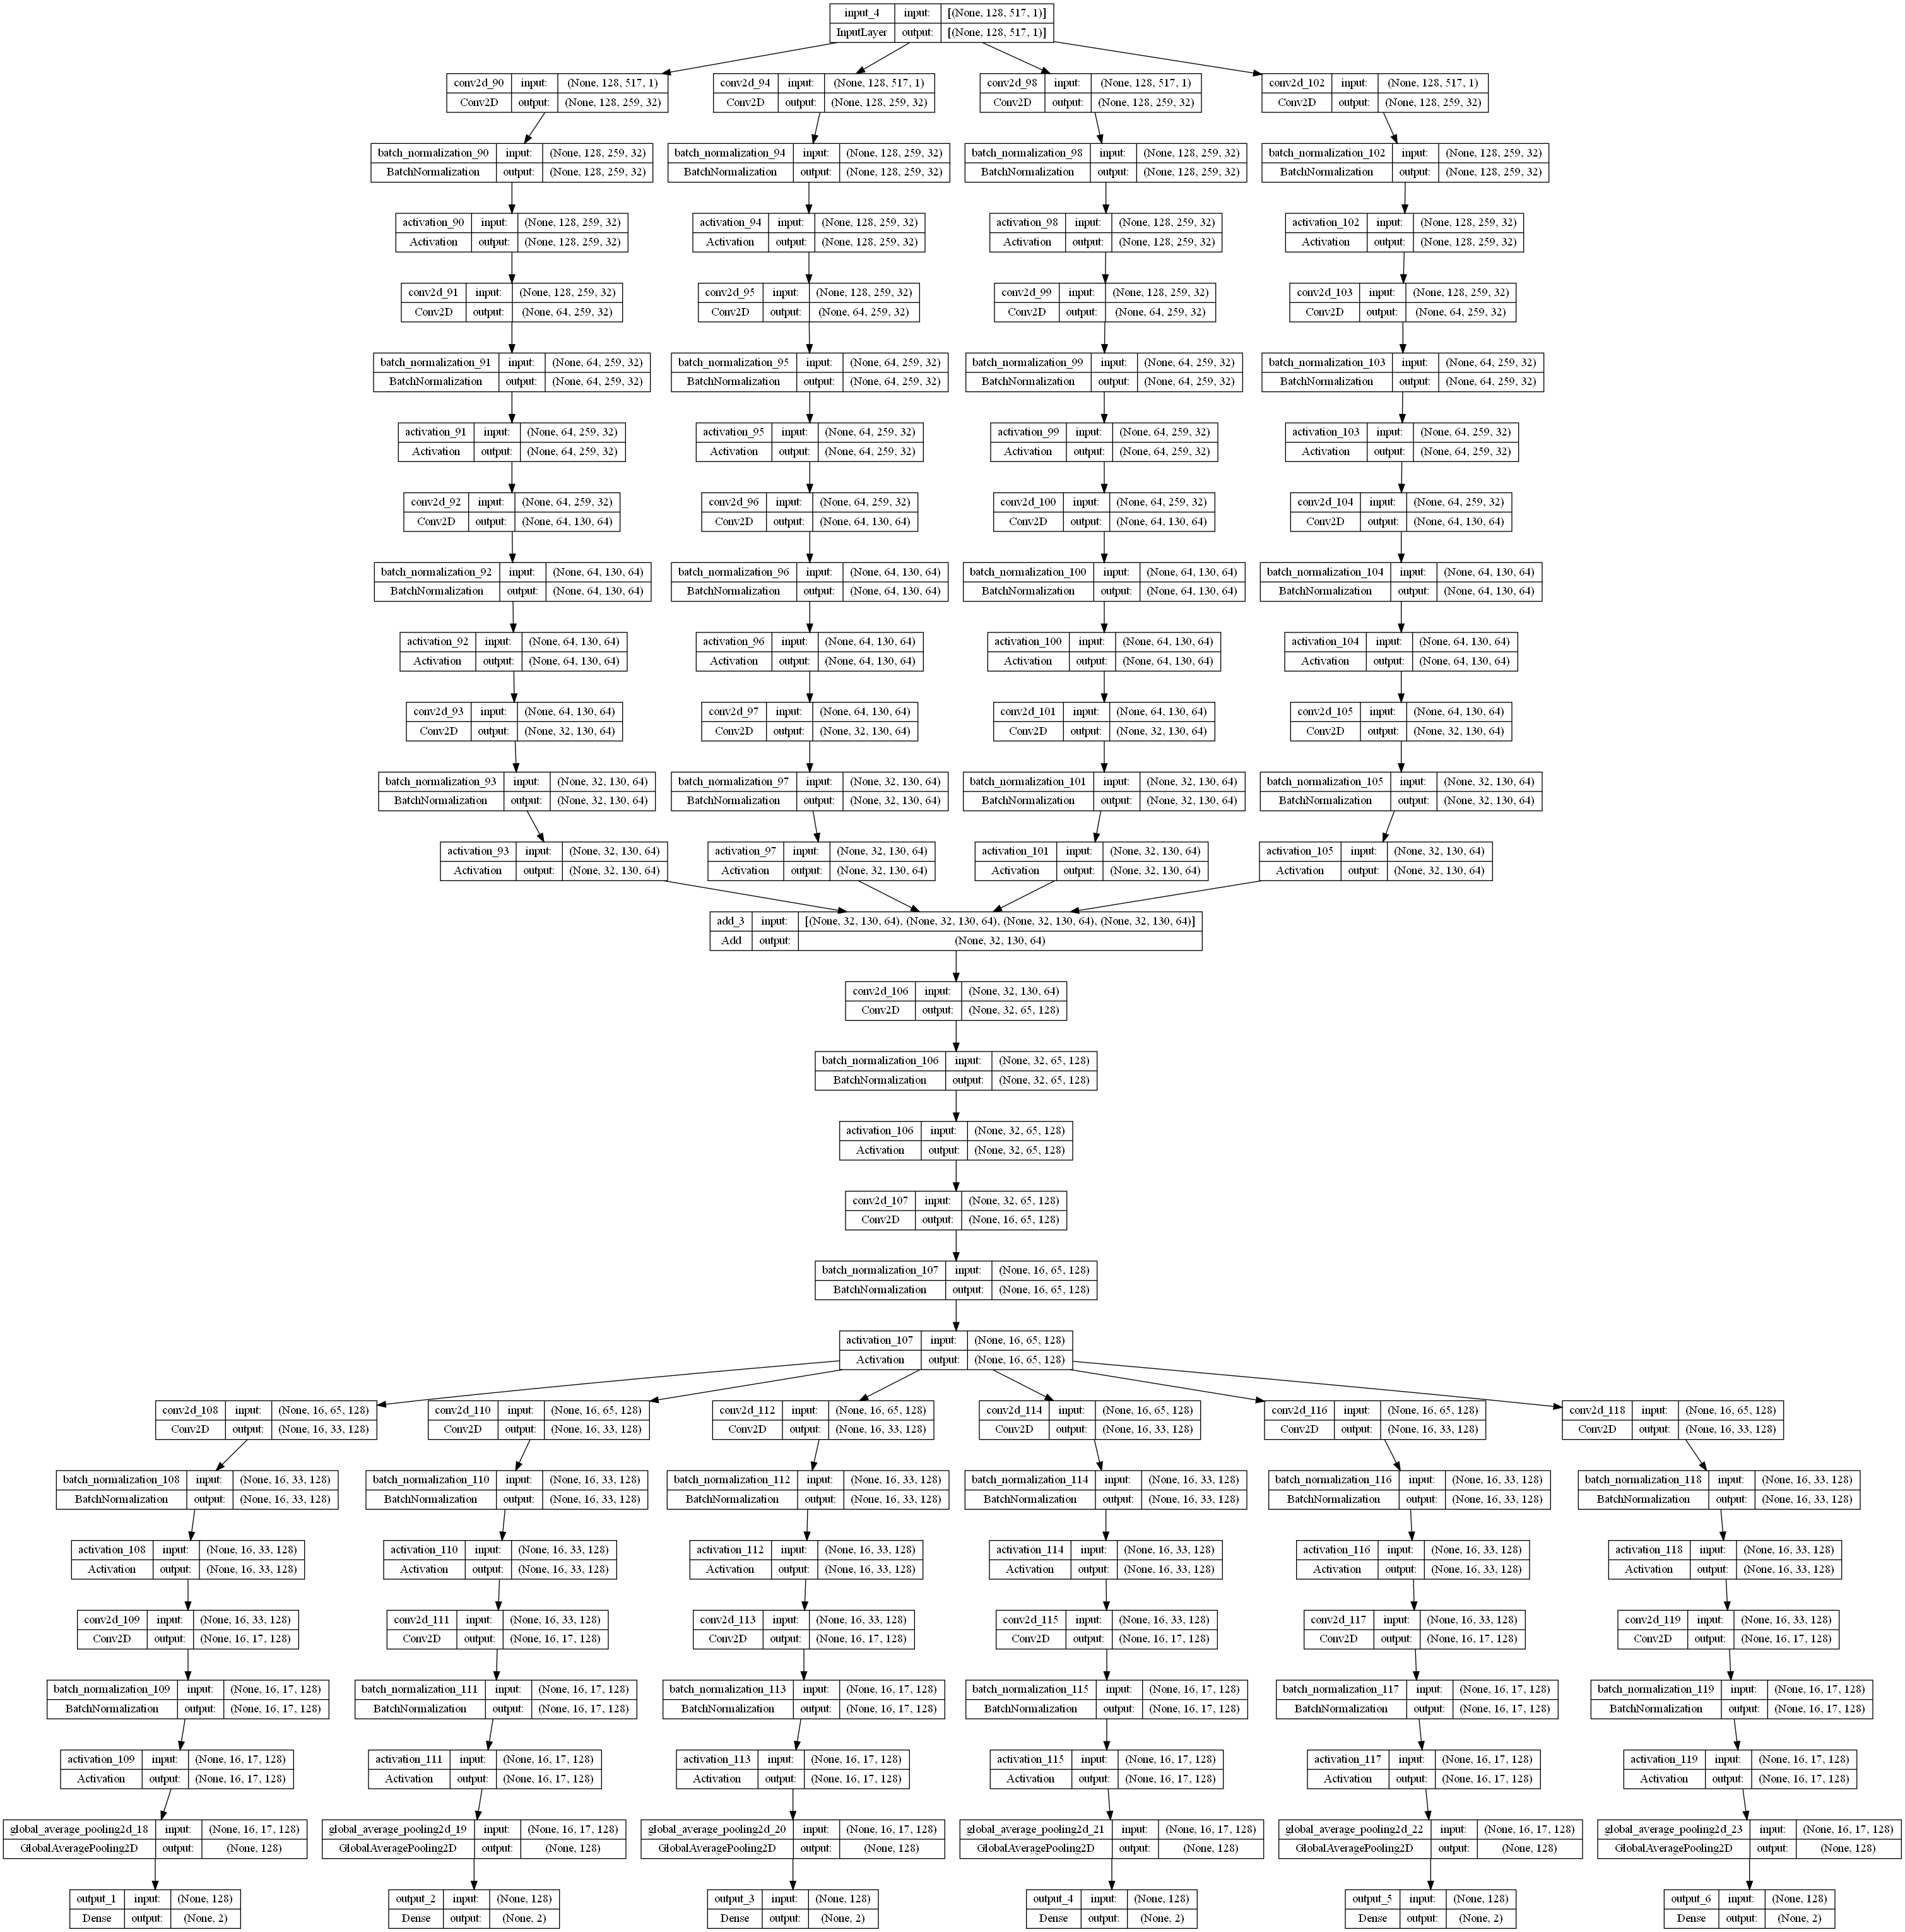

In [97]:
plot_model(
    model,
    show_shapes=True,
)

In [98]:
model_dir = "./../models_each"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

In [99]:
es_cb = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
chkpt = os.path.join(model_dir, 'esc50_.{epoch:02d}_{val_loss:.4f}_{output_1_accuracy:.4f}_{output_2_accuracy:.4f}_{output_3_accuracy:.4f}_{output_4_accuracy:.4f}_{output_5_accuracy:.4f}_{output_6_accuracy:.4f}.hdf5')
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [101]:
batch_size = 16
epochs = 10

start_time = ti.time()
with tensorflow.device('/GPU:0'):
    
    model.fit(x_train, 
              {'output_1': y_train_1, 
               'output_2': y_train_2,
               'output_3': y_train_3,
               'output_4': y_train_4,
               'output_5': y_train_5,
               'output_6': y_train_6},
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test,
                               {'output_1': y_test_1,
                                'output_2': y_test_2,
                                'output_3': y_test_3,
                                'output_4': y_test_4,
                                'output_5': y_test_5,
                                'output_6': y_test_6}),
              verbose=1,
              callbacks=[es_cb, cp_cb])

    
end_time = ti.time()
print("time:", end_time - start_time)

Epoch 1/10
63/63 [==============================] - ETA: 0s - loss: 1.5475 - output_1_loss: 0.2710 - output_2_loss: 0.2901 - output_3_loss: 0.2588 - output_4_loss: 0.2716 - output_5_loss: 0.1778 - output_6_loss: 0.2781 - output_1_accuracy: 0.8849 - output_2_accuracy: 0.8839 - output_3_accuracy: 0.8770 - output_4_accuracy: 0.8611 - output_5_accuracy: 0.9335 - output_6_accuracy: 0.8730
Epoch 1: val_loss improved from inf to 6.61782, saving model to ./../models_each\esc50_.01_6.6178_0.8849_0.8839_0.8770_0.8611_0.9335_0.8730.hdf5
63/63 [==============================] - 41s 375ms/step - loss: 1.5475 - output_1_loss: 0.2710 - output_2_loss: 0.2901 - output_3_loss: 0.2588 - output_4_loss: 0.2716 - output_5_loss: 0.1778 - output_6_loss: 0.2781 - output_1_accuracy: 0.8849 - output_2_accuracy: 0.8839 - output_3_accuracy: 0.8770 - output_4_accuracy: 0.8611 - output_5_accuracy: 0.9335 - output_6_accuracy: 0.8730 - val_loss: 6.6178 - val_output_1_loss: 0.2686 - val_output_2_loss: 1.0732 - val_outp

In [110]:
model = load_model("./../models_each/esc50_.07_0.1678_0.9950_0.9921_0.9891_0.9891_0.9921_0.9891.hdf5")

In [111]:
evaluation = model.evaluate(x_test, {'output_1': y_test_1,
                                     'output_2': y_test_2,
                                     'output_3': y_test_3,
                                     'output_4': y_test_4,
                                     'output_5': y_test_5,
                                     'output_6': y_test_6})
print(evaluation)

2/2 [==============================] - 2s 57ms/step - loss: 0.1678 - output_1_loss: 0.1144 - output_2_loss: 0.0081 - output_3_loss: 0.0026 - output_4_loss: 4.2495e-04 - output_5_loss: 0.0329 - output_6_loss: 0.0094 - output_1_accuracy: 0.9762 - output_2_accuracy: 1.0000 - output_3_accuracy: 1.0000 - output_4_accuracy: 1.0000 - output_5_accuracy: 0.9762 - output_6_accuracy: 1.0000
[0.16778746247291565, 0.11437255144119263, 0.008092416450381279, 0.002583577763289213, 0.00042495044181123376, 0.0328780859708786, 0.009435871616005898, 0.976190447807312, 1.0, 1.0, 1.0, 0.976190447807312, 1.0]


001000_020.wav
wave size:(66150,)
melsp size:(128, 517)
sampling rate:22050


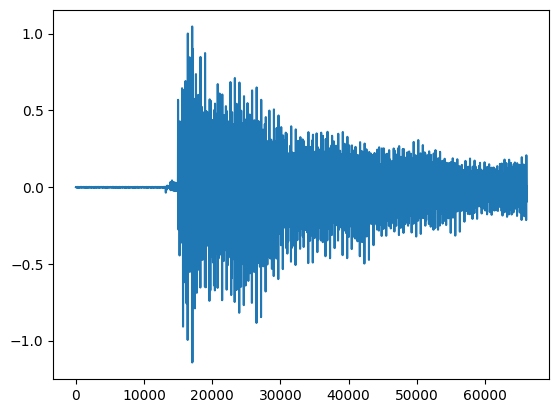

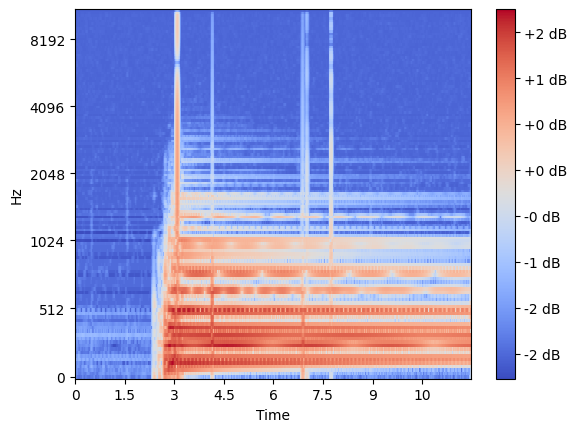

In [119]:
file_name = asses_name_list[3] + "_" + str(20).zfill(3) + ".wav"
print(file_name)
x, fs = load_wave_data(dataset_dir, file_name)
melsp = calculate_melsp(x)
print("wave size:{0}\nmelsp size:{1}\nsampling rate:{2}".format(x.shape, melsp.shape, fs))
show_wave(x)
show_melsp(melsp, fs)

In [120]:
ipd.Audio(x, rate=fs)

In [122]:
pred = model.predict(melsp.reshape(1, 128, 517, 1))

1/1 [==============================] - 0s 20ms/step


In [123]:
pred

[array([[9.9989021e-01, 1.0983498e-04]], dtype=float32),
 array([[9.9962425e-01, 3.7571375e-04]], dtype=float32),
 array([[0.04101324, 0.95898676]], dtype=float32),
 array([[0.99314207, 0.00685795]], dtype=float32),
 array([[9.9973541e-01, 2.6462867e-04]], dtype=float32),
 array([[9.99602e-01, 3.97988e-04]], dtype=float32)]

In [124]:
pred_label_1 = np.argmax(pred[0])
pred_label_2 = np.argmax(pred[1])
pred_label_3 = np.argmax(pred[2])
pred_label_4 = np.argmax(pred[3])
pred_label_5 = np.argmax(pred[4])
pred_label_6 = np.argmax(pred[5])

In [125]:
print(f"predicted output 1: {pred_label_1}\npredicted output 2: {pred_label_2}\npredicted output 3: {pred_label_3}\npredicted output 4: {pred_label_4}\npredicted output 5: {pred_label_5}\npredicted output 6: {pred_label_6}")

predicted output 1: 0
predicted output 2: 0
predicted output 3: 1
predicted output 4: 0
predicted output 5: 0
predicted output 6: 0


## 推論 

In [127]:
import sounddevice as sd

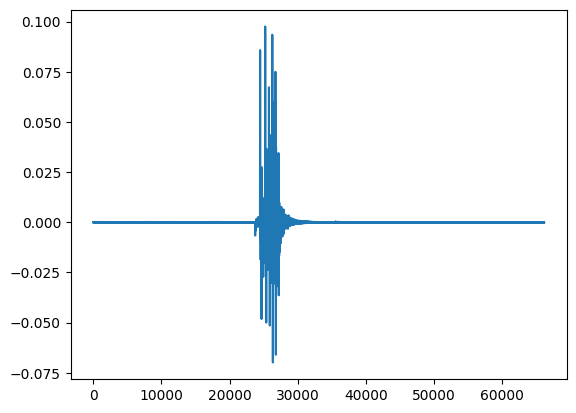

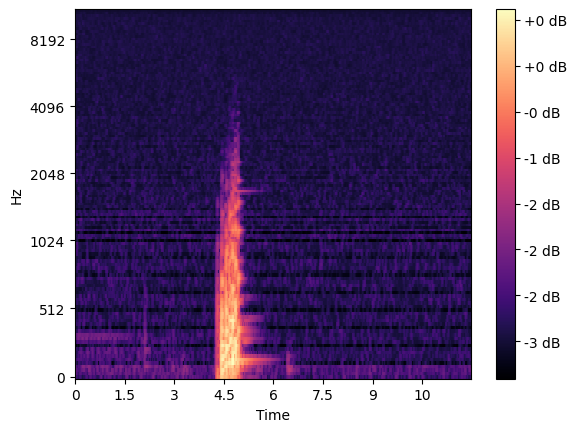

1/1 [==============================] - 0s 20ms/step
predicted output 1: 0
predicted output 2: 0
predicted output 3: 1
predicted output 4: 0
predicted output 5: 0
predicted output 6: 0


In [134]:
fs = 22050
sd.default.device = [1, 10]
duration = 3

data = sd.rec(int(duration * fs), samplerate=fs, channels=1)
sd.wait()

x = data.reshape(len(data))
melsp = calculate_melsp(x)
show_wave(x)
show_melsp(melsp, fs)

pred = model.predict(melsp.reshape(1, 128, 517, 1))
pred_label_1 = np.argmax(pred[0])
pred_label_2 = np.argmax(pred[1])
pred_label_3 = np.argmax(pred[2])
pred_label_4 = np.argmax(pred[3])
pred_label_5 = np.argmax(pred[4])
pred_label_6 = np.argmax(pred[5])
print(f"predicted output 1: {pred_label_1}\npredicted output 2: {pred_label_2}\npredicted output 3: {pred_label_3}\npredicted output 4: {pred_label_4}\npredicted output 5: {pred_label_5}\npredicted output 6: {pred_label_6}")

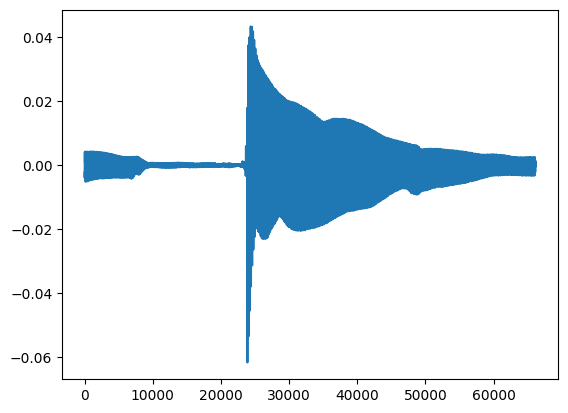

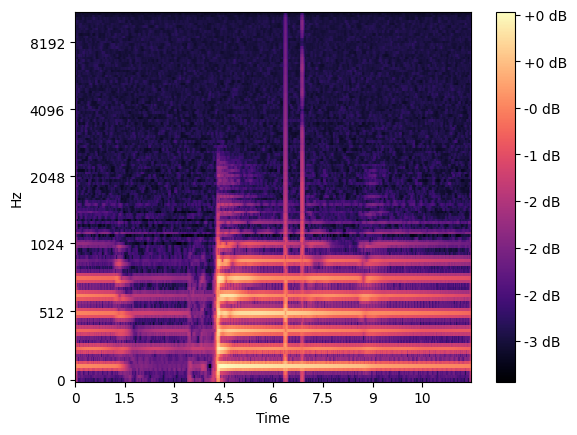

In [135]:
fs = 22050
sd.default.device = [1, 10]
duration = 3

data = sd.rec(int(duration * fs), samplerate=fs, channels=1)
sd.wait()

x = data.reshape(len(data))
melsp = calculate_melsp(x)
show_wave(x)
show_melsp(melsp, fs)

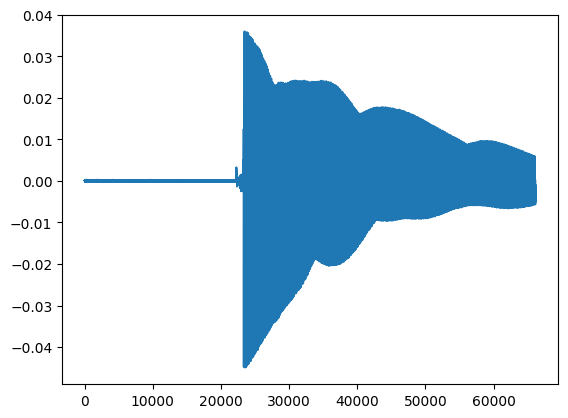

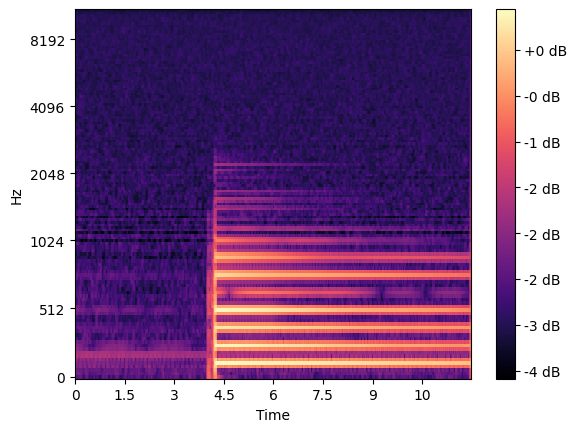

In [136]:
fs = 22050
sd.default.device = [1, 10]
duration = 3

data = sd.rec(int(duration * fs), samplerate=fs, channels=1)
sd.wait()

x = data.reshape(len(data))
melsp = calculate_melsp(x)
show_wave(x)
show_melsp(melsp, fs)